<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl, pandas as pd
import pcmdpy as ppy
%matplotlib inline

GPU acceleration enabled


In [2]:
try:
    ppy.gpu_utils.initialize_gpu(n=0)
    __GPU_AVAIL = True
except:
    __GPU_AVAIL = False

using given n: 0
Starting SourceModule Code
Past the SourceModule code
CUDAC Available


In [3]:
f_base = ppy.instrument.default_m51_filters()
f_low = ppy.instrument.default_m51_filters()
for f in f_low:
    f._exposure /= 4.

In [4]:
results = {}
results['base'] = ppy.plotting.ResultsPlotter('results/m51_arm2_twostage_v11_init.csv',
                                              run_name='Baseline')

In [5]:
results['log'] = ppy.plotting.ResultsPlotter('results/m51_arm2_twostage_loghess_v2_init.csv',
                                             run_name='LogHess')
results['quarter'] = ppy.plotting.ResultsPlotter('results/m51_arm2_twostage_quarter_v2_init.csv',
                                                run_name='QuarterExp')
results['quarter_log'] = ppy.plotting.ResultsPlotter('results/m51_arm2_twostage_quarter_log_v2_init.csv',
                                                    run_name='Quarter + Log')

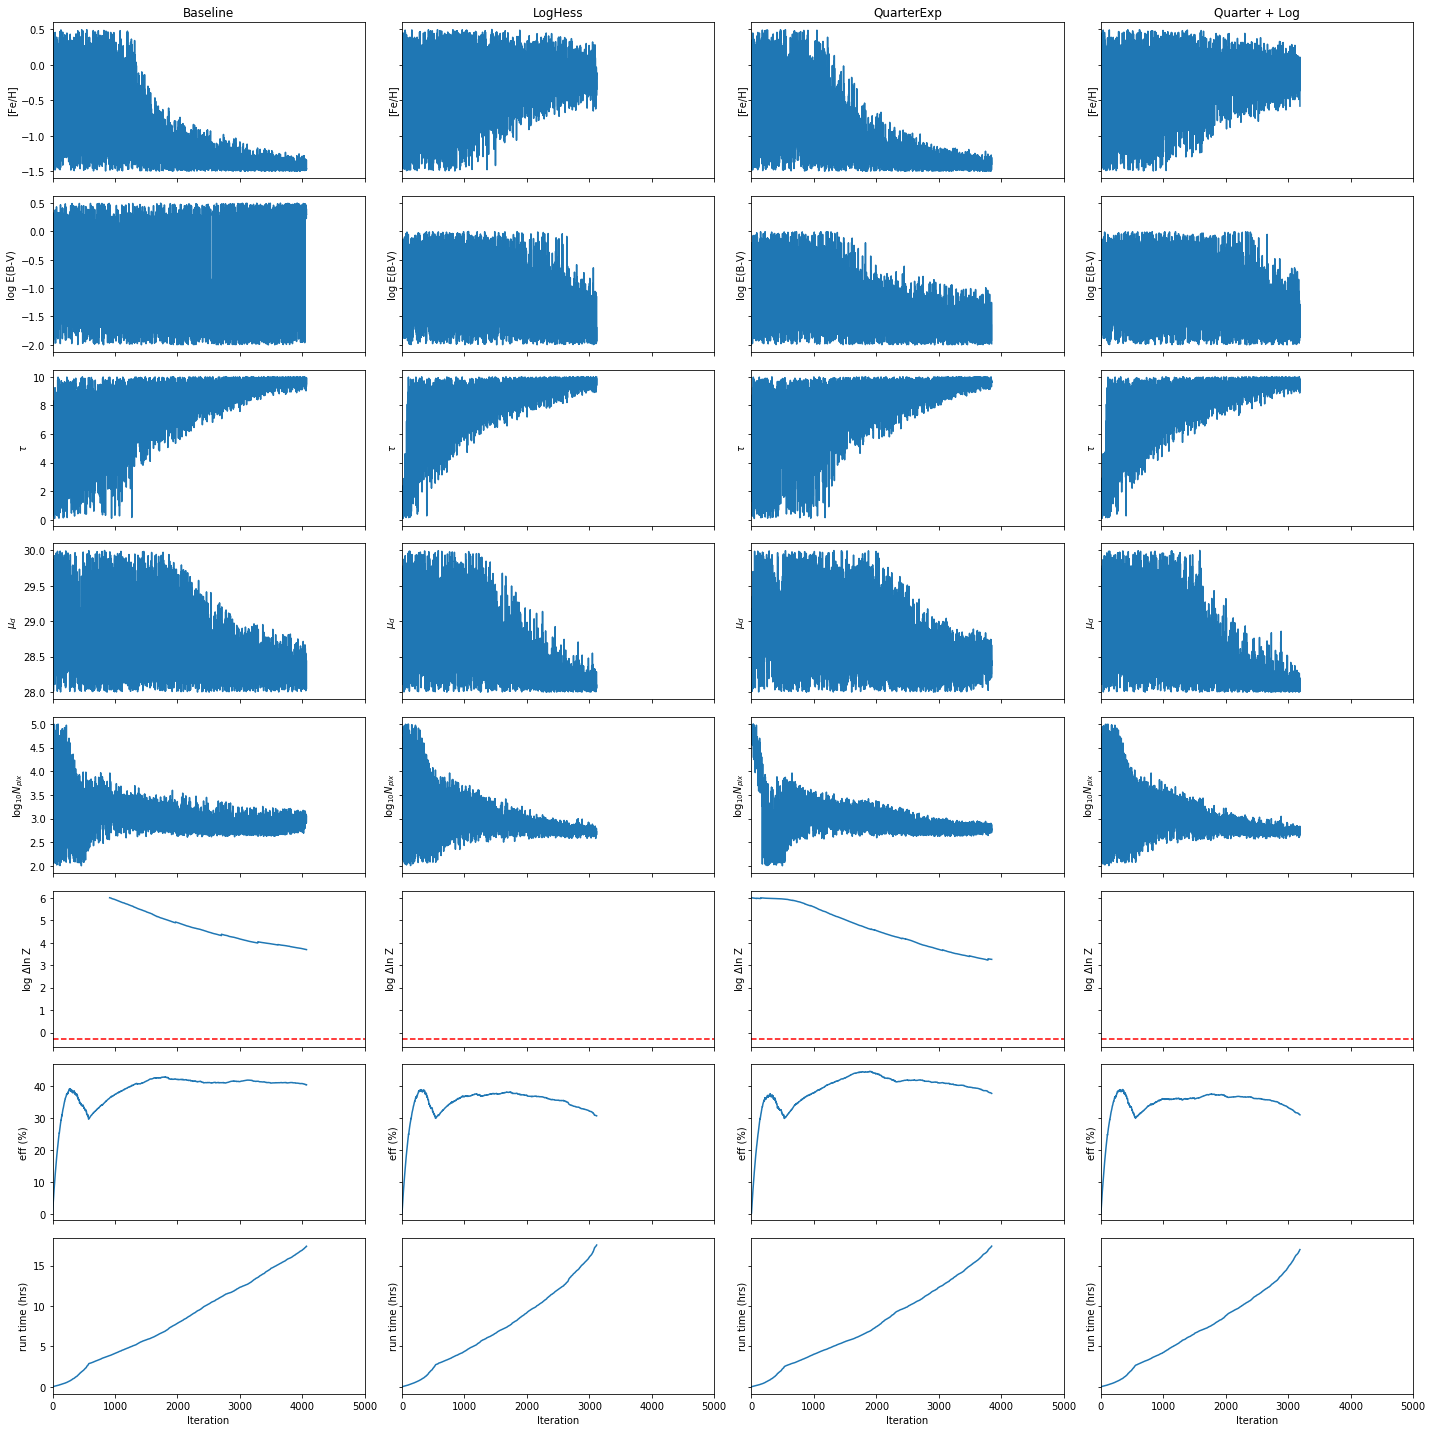

In [6]:
fig, axes = plt.subplots(ncols=4, nrows=8, sharey='row', sharex=True, figsize=(20, 20))
results['base'].plot_chains(axes=axes[:,0]);
results['log'].plot_chains(axes=axes[:,1]);
results['quarter'].plot_chains(axes=axes[:,2]);
results['quarter_log'].plot_chains(axes=axes[:,3]);
axes[0,0].set_xlim(xmax=5000)
plt.tight_layout()

In [7]:
iso_base = ppy.isochrones.Isochrone_Model(f_base, dm_interp=-1)
iso_low = ppy.isochrones.Isochrone_Model(f_low, dm_interp=-1)

In [8]:
driv_base = ppy.driver.Driver(iso_base, gpu=__GPU_AVAIL)
driv_low = ppy.driver.Driver(iso_low, gpu=__GPU_AVAIL)

In [9]:
pcmds = {}

In [10]:
pcmds['data'] = np.loadtxt('../data/m51_arm2_I-VI-BV.dat', unpack=True)

In [32]:
n_data = int(np.sqrt(pcmds['data'].shape[1])) * 4

In [12]:
bins = [np.arange(23, 30, 0.1), np.arange(-2, 3, 0.1), np.arange(-2, 3, 0.1)]

In [13]:
sky_base = np.array([84., 41., 54.])
sky_low = sky_base / 4.

In [14]:
results['log'].df[results['log'].params].tail()

,logfeh_mean,logdust_med,tau,dmod,logNpix
3114,-0.14342,-1.7986,9.5820,28.287,2.7882
3115,-0.12072,-1.6873,9.8920,28.109,2.6978
3116,-0.43259,-1.7666,9.7250,28.092,2.6547
3117,-0.10781,-1.9385,9.3968,28.054,2.6809
3118,-0.34247,-1.1549,9.9673,28.097,2.7177


In [15]:
g1 = ppy.galaxy.TauFull(np.array([-1.4656, 0.302, 3.0482, 9.366, 28.44]))
g2 = ppy.galaxy.TauFull(np.array([0., -1., 3.3, 10., 29.67]))
g3 = ppy.galaxy.TauFull(results['log'].df[['logfeh_mean', 'logdust_med', 'logNpix', 'tau', 'dmod']].values[-1])

In [33]:
%%time
pcmds['g1_base'] = driv_base.simulate(g1, n_data, fixed_seed=True,
                                      shot_noise=True, sky_noise=sky_base, downsample=5)[0]

CPU times: user 7.37 s, sys: 2.6 s, total: 9.97 s
Wall time: 11.1 s


In [34]:
%%time
pcmds['g2_base'] = driv_base.simulate(g2, n_data, fixed_seed=True,
                                      shot_noise=True, sky_noise=sky_base, downsample=5)[0]

CPU times: user 7.38 s, sys: 2.58 s, total: 9.96 s
Wall time: 10.4 s


In [35]:
%%time
pcmds['g3_base'] = driv_base.simulate(g3, n_data, fixed_seed=True,
                                      shot_noise=True, sky_noise=sky_base, downsample=5)[0]

CPU times: user 7.26 s, sys: 2.6 s, total: 9.86 s
Wall time: 10.3 s


In [36]:
%%time
pcmds['g1_low'] = driv_low.simulate(g1, n_data, fixed_seed=True,
                                    shot_noise=True, sky_noise=sky_low, downsample=5)[0]

CPU times: user 7.56 s, sys: 2.57 s, total: 10.1 s
Wall time: 10.6 s


In [37]:
%%time
pcmds['g2_low'] = driv_low.simulate(g2, n_data, fixed_seed=True,
                                    shot_noise=True, sky_noise=sky_low, downsample=5)[0]

CPU times: user 7.66 s, sys: 2.58 s, total: 10.2 s
Wall time: 10.7 s


In [38]:
%%time
pcmds['g3_low'] = driv_low.simulate(g3, n_data, fixed_seed=True,
                                    shot_noise=True, sky_noise=sky_low, downsample=5)[0]

CPU times: user 7.51 s, sys: 2.67 s, total: 10.2 s
Wall time: 10.6 s


In [39]:
def compare(key, lm=2):
    fig, axes = plt.subplots(ncols=3, nrows=2, sharey=True, sharex='row', figsize=(15, 10))
    norm = mpl.colors.LogNorm()
#     norm = None
    kwargs = {'normed':True}
    pcmd_model = pcmds[key]
    pcmd_data = pcmds['data']
    ppy.plotting.plot_pcmd(pcmd_model, bins=bins, axes=axes[:,0], norm=norm, title=key, hist2d_kwargs=kwargs)
    ppy.plotting.plot_pcmd(pcmd_data, bins=bins, axes=axes[:,1], norm=norm, hist2d_kwargs=kwargs)
    ppy.plotting.plot_pcmd_residual(pcmd_model, pcmd_data, bins=bins, axes=axes[:,2], like_mode=lm)
    ppy.plotting.plot_isochrone(iso_base, axes=axes[:,0])
    ppy.plotting.plot_isochrone(iso_base, axes=axes[:,1])
    ppy.plotting.plot_isochrone(iso_base, axes=axes[:,2])
    axes[0,0].set_ylim([28, 23])
    plt.tight_layout()
    plt.colorbar(ax=axes, label=r'$\pm \chi^2$')
    return axes

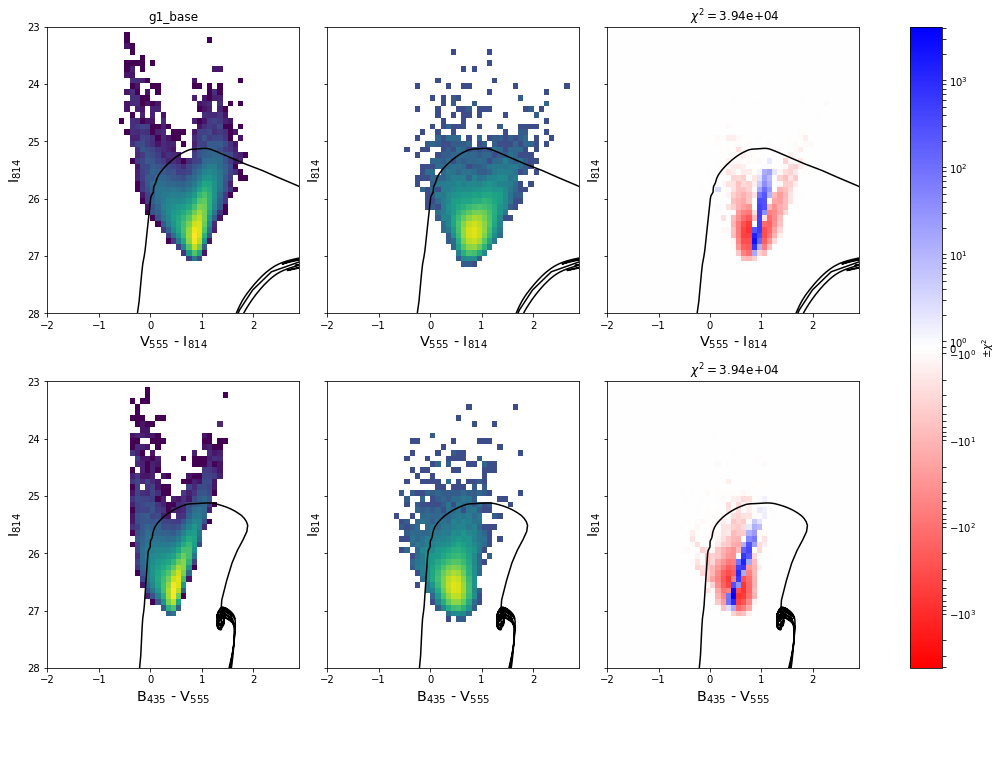

In [55]:
compare('g1_base', lm=2);

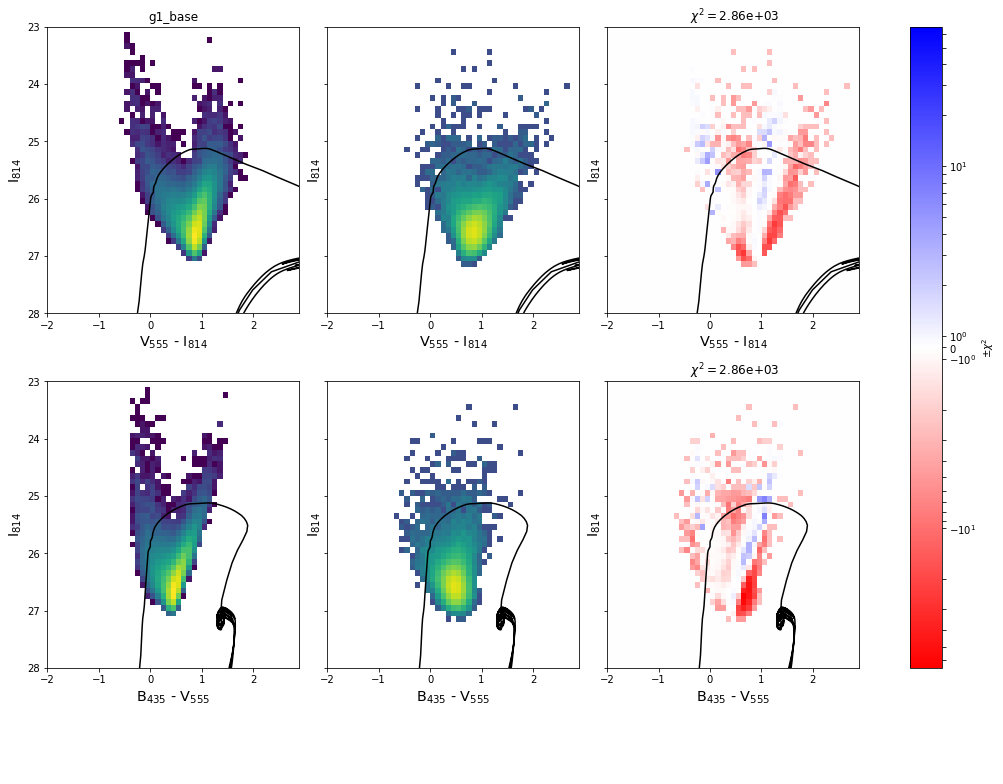

In [56]:
compare('g1_base', lm=1);

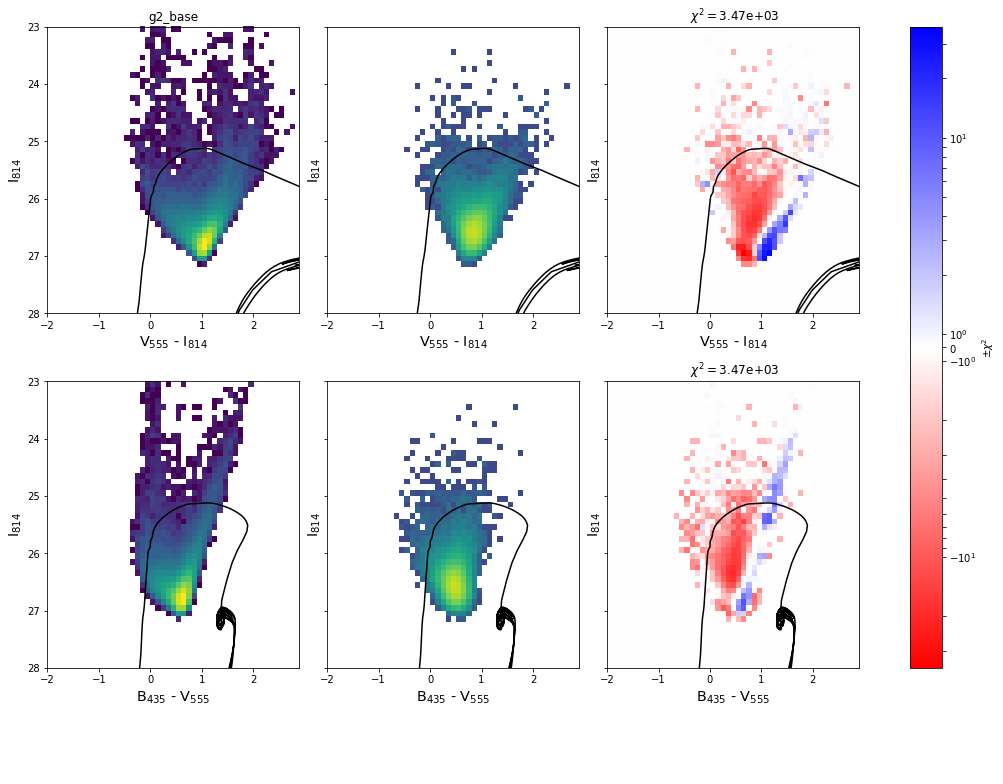

In [49]:
compare('g2_base', lm=1);

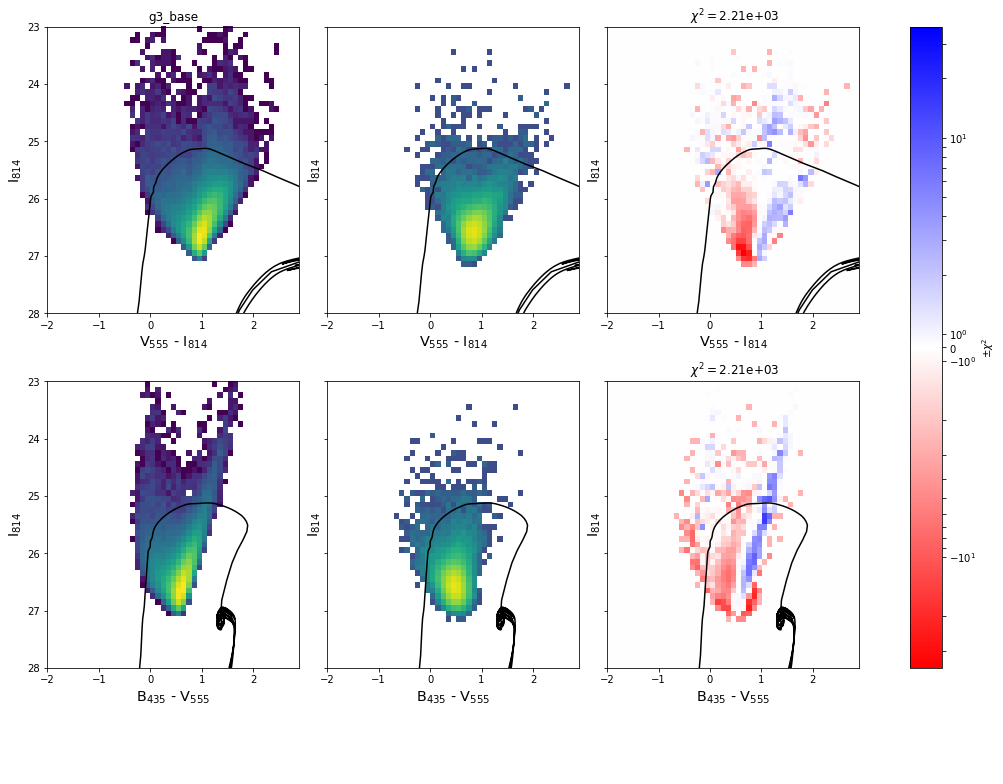

In [46]:
compare('g3_base', lm=1);

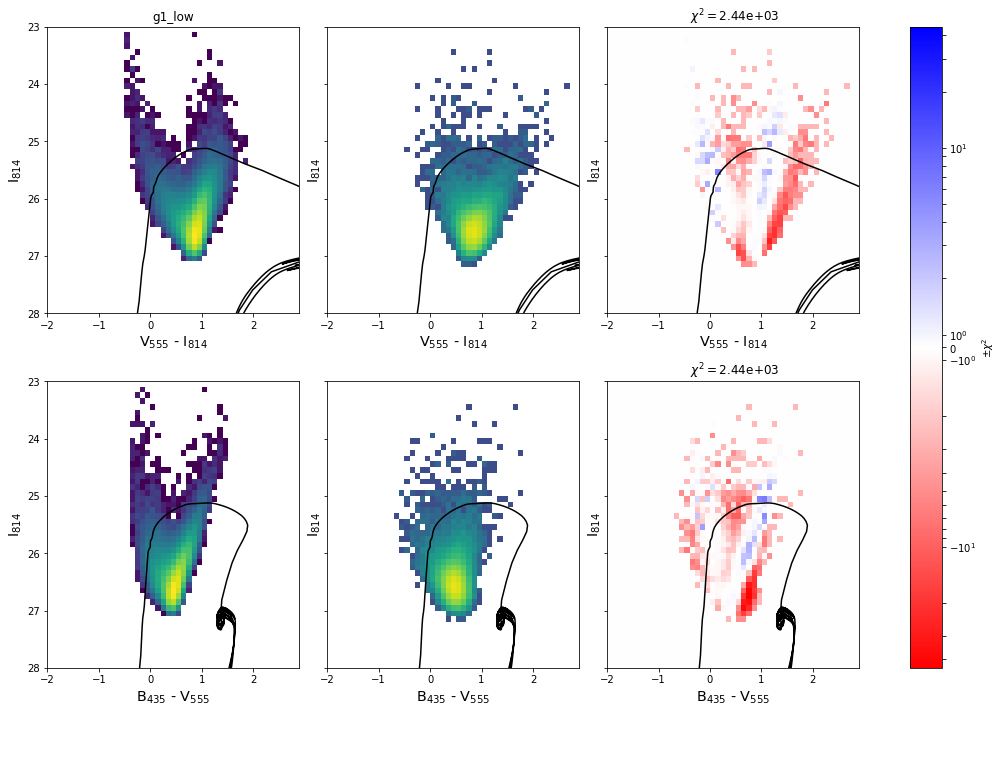

In [51]:
compare('g1_low', lm=1);

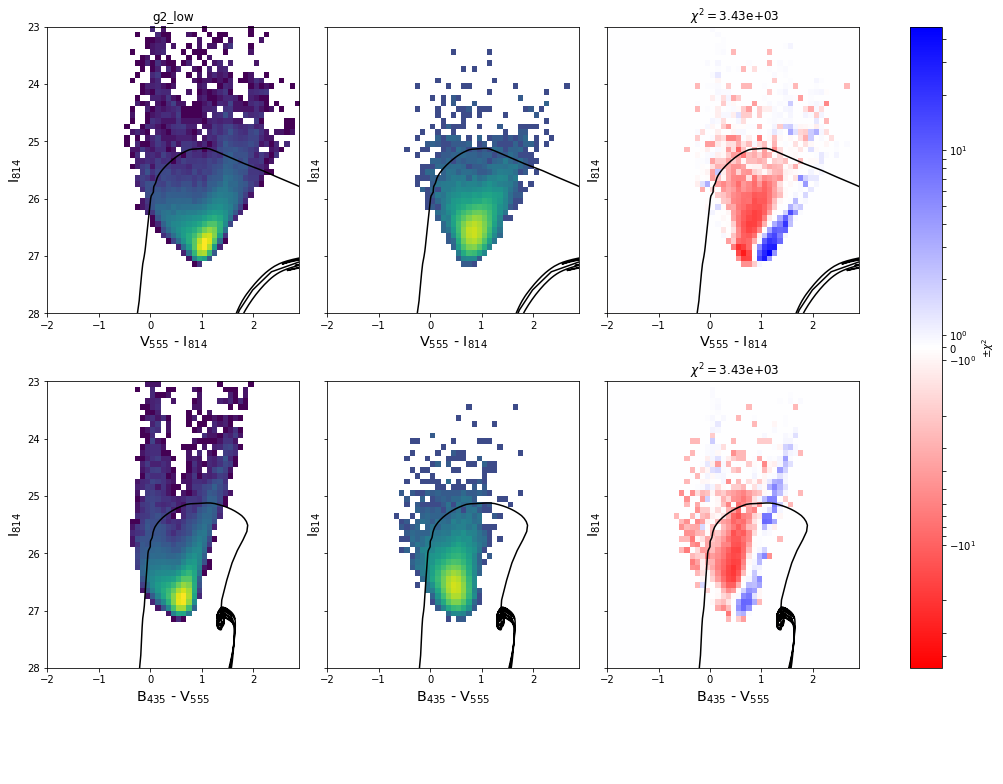

In [52]:
compare('g2_low', lm=1);

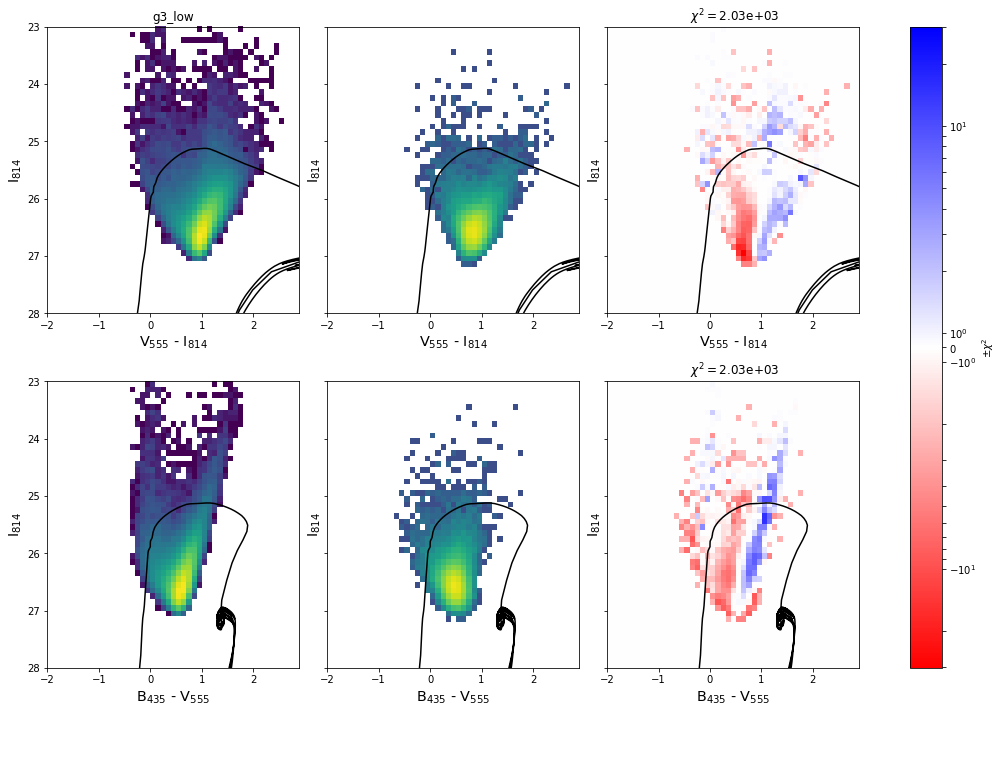

In [53]:
compare('g3_low', lm=1);